IMPORT LIBRARIES

In [1]:
# Import Relevant Libraries
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy import interpolate

In [2]:
def visualize_find_match(img1, img2, x1, x2, img_h=500):
    assert x1.shape == x2.shape, 'x1 and x2 should have same shape!'
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    x1 = x1 * scale_factor1
    x2 = x2 * scale_factor2
    x2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    for i in range(x1.shape[0]):
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'b')
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'bo')
    plt.axis('off')
    plt.show()

In [3]:
def visualize_align_image(template, target, A, A_refined, errors=None):
    img_warped_init = warp_image(target, A, template.shape)
    img_warped_optim = warp_image(target, A_refined, template.shape)
    err_img_init = np.abs(img_warped_init - template)
    err_img_optim = np.abs(img_warped_optim - template)
    img_warped_init = np.uint8(img_warped_init)
    img_warped_optim = np.uint8(img_warped_optim)
    overlay_init = cv2.addWeighted(template, 0.5, img_warped_init, 0.5, 0)
    overlay_optim = cv2.addWeighted(template, 0.5, img_warped_optim, 0.5, 0)
    plt.subplot(241)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(242)
    plt.imshow(img_warped_init, cmap='gray')
    plt.title('Initial warp')
    plt.axis('off')
    plt.subplot(243)
    plt.imshow(overlay_init, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(244)
    plt.imshow(err_img_init, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.subplot(245)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(246)
    plt.imshow(img_warped_optim, cmap='gray')
    plt.title('Opt. warp')
    plt.axis('off')
    plt.subplot(247)
    plt.imshow(overlay_optim, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(248)
    plt.imshow(err_img_optim, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.show()

    # if errors is not None:
    #     plt.plot(errors * 255)
    #     plt.xlabel('Iteration')
    #     plt.ylabel('Error')
    #     plt.show()

    if errors is not None:
        plt.plot(np.arange(len(errors)),errors)
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.show()


In [4]:
def visualize_track_multi_frames(template, img_list, A_list):
    bbox_list = []
    for A in A_list:
        boundary_t = np.hstack((np.array([[0, 0], [template.shape[1], 0], [template.shape[1], template.shape[0]],
                                        [0, template.shape[0]], [0, 0]]), np.ones((5, 1)))) @ A[:2, :].T
        bbox_list.append(boundary_t)

    plt.subplot(221)
    plt.imshow(img_list[0], cmap='gray')
    plt.plot(bbox_list[0][:, 0], bbox_list[0][:, 1], 'r')
    plt.title('Frame 1')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(img_list[1], cmap='gray')
    plt.plot(bbox_list[1][:, 0], bbox_list[1][:, 1], 'r')
    plt.title('Frame 2')
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(img_list[2], cmap='gray')
    plt.plot(bbox_list[2][:, 0], bbox_list[2][:, 1], 'r')
    plt.title('Frame 3')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(img_list[3], cmap='gray')
    plt.plot(bbox_list[3][:, 0], bbox_list[3][:, 1], 'r')
    plt.title('Frame 4')
    plt.axis('off')
    plt.show()

In [5]:
def visualize_align_image_using_feature(img1, img2, x1, x2, A, ransac_thr, img_h=500):
    x2_t = np.hstack((x1, np.ones((x1.shape[0], 1)))) @ A.T
    errors = np.sum(np.square(x2_t[:, :2] - x2), axis=1)
    mask_inliers = errors < ransac_thr
    boundary_t = np.hstack(( np.array([[0, 0], [img1.shape[1], 0], [img1.shape[1], img1.shape[0]], [0, img1.shape[0]], [0, 0]]), np.ones((5, 1)) )) @ A[:2, :].T

    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    x1 = x1 * scale_factor1
    x2 = x2 * scale_factor2
    x2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

    boundary_t = boundary_t * scale_factor2
    boundary_t[:, 0] += img1_resized.shape[1]
    plt.plot(boundary_t[:, 0], boundary_t[:, 1], 'y')
    for i in range(x1.shape[0]):
        if mask_inliers[i]:
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'g')
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'go')
        else:
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'r')
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'ro')
    plt.axis('off')
    plt.show()

In [14]:
def find_match(img1, img2):
    # To do
    # Create a sift object.
    sift = cv2.SIFT_create()

    # Extract the keypoints and the corresponding descriptors.
    keypoints_1, descriptor_1 = sift.detectAndCompute(img1, None)
    keypoints_2, desciptior_2 = sift.detectAndCompute(img2, None)

    # Create a Nearest Neighbour object.
    neigh = NearestNeighbors(n_neighbors = 2) # We only need two points, second point is used for ratio test.
    
    # Fit the algo to the data that we have, we fit the second image and run the algo for points in img1.
    neigh.fit(desciptior_2)
    distances, indices = neigh.kneighbors(descriptor_1, n_neighbors = 2, return_distance=True )

    # Find the distance ratio between first and second value.
    distance_ratio = distances[:,0]/distances[:,1]

    # Get the indices of points which correspond to each other from the two images.
    indices_1 = np.where(distance_ratio < 0.7)[0]
    indices_2 = indices[np.where(distance_ratio < 0.7)][:,0]

    # Get the coordinates of points and store in x1, x2
    x1 = np.array([[keypoints_1[i].pt[0], keypoints_1[i].pt[1]] for i in indices_1])
    x2 = np.array([[keypoints_2[i].pt[0], keypoints_2[i].pt[1]] for i in indices_2])

    return x1, x2

In [148]:
def align_image_using_feature_homo(x1, x2, ransac_thr, ransac_iter):
    # To do
    # Go in a loop for number of iterations.
    max_inliner = 0
    for iter in range(ransac_iter):
        # Get index points of four points from a list of indieces.
        index_points = np.random.choice(len(x1), 4,replace=False) # Output will a numpy array.
        
        # get four random points from the data.
        # Create a 8*8 matrix of A.
        u1, v1 = x1[index_points[0]][0], x1[index_points[0]][1]
        u2, v2 = x1[index_points[1]][0], x1[index_points[1]][1]
        u3, v3 = x1[index_points[2]][0], x1[index_points[2]][1]
        u4, v4 = x1[index_points[3]][0], x1[index_points[3]][1]
        u1_, v1_ = x2[index_points[0]][0], x2[index_points[0]][1]
        u2_, v2_ = x2[index_points[1]][0], x2[index_points[1]][1]
        u3_, v3_ = x2[index_points[2]][0], x2[index_points[2]][1]
        u4_, v4_ = x2[index_points[3]][0], x2[index_points[3]][1]
        temp_A = np.array([[u1, v1, 1, 0, 0, 0, -u1*u1_, -v1*u1_],
                            [0, 0, 0, u1, v1, 1, -u1*v1_, -v1*v1_],
                            [u2, v2, 1, 0, 0, 0, -u2*u2_, -v2*u2_],
                            [0, 0, 0, u2, v2, 1, -u2*v2_, -v2*v2_],
                            [u3, v3, 1, 0, 0, 0, -u3*u3_, -v3*u3_],
                            [0, 0, 0, u3, v3, 1, -u3*v3_, -v3*v3_],
                            [u4, v4, 1, 0, 0, 0, -u4*u4_, -v4*u4_],
                            [0, 0, 0, u4, v4, 1, -u4*v4_, -v4*v4_],])
        
        # Create a b matrix.
        b = np.array([  u1_,
                        v1_,
                        u2_,
                        v2_,
                        u3_,
                        v3_,
                        u4_,
                        v4_])
        
        # Find the h matrix (x matrix)
        # x = (AT A ) -1 AT b
        x = np.matmul( np.matmul( np.linalg.inv( np.matmul(temp_A.T, temp_A)), temp_A.T) , b)

        # Find the inliners and outliners in the data.
        # Go into a loop over all items.
        x2_predicted = np.zeros(x1.shape)
        for i,point in enumerate(x1):
            x2_predicted[i][0] = (x[0]*point[0] + x[1]*point[1] + x[2])/(x[6]*point[0] + x[7]*point[1] + 1)
            x2_predicted[i][1] = (x[3]*point[0] + x[4]*point[1] + x[5])/(x[6]*point[0] + x[7]*point[1] + 1)

        # Find distance between the two points in the array.
        error = np.sqrt(np.square(x2[:,0] - x2_predicted[:,0]) + np.square(x2[:,1] - x2_predicted[:,1]))
        inliners = len(np.where(error < ransac_thr))
        if inliners > max_inliner:
            A = temp_A
            A = np.array([[x[0], x[1], x[2]],
                          [x[3], x[4], x[5]],
                          [x[6], x[7], 1]])
            x1_ret = x1[np.where(error < ransac_thr)]
            x2_ret = x2[np.where(error < ransac_thr)]
            max_inliner = inliners
            x1_outliners = x1[np.where(error > ransac_thr)]
            x2_outliners = x2[np.where(error > ransac_thr)]
    # This return is wrong A is supposed to be the 3*3 matrix.
    return A, x1_ret, x2_ret, x1_outliners, x2_outliners

In [149]:
def align_image_using_feature(x1, x2, ransac_thr, ransac_iter):
    # To do
    # Go in a loop for number of iterations.
    np.random.seed(32)
    max_inliner = 0
    for iter in range(ransac_iter):
        # Get index points of four points from a list of indieces. We need three correspondance points for a Affine transformation.
        index_points = np.random.choice(len(x1), 3,replace=False) # Output will a numpy array.
        
        # get three random points from the data.
        # Create a 8*8 matrix of A.
        u1, v1 = x1[index_points[0]][0], x1[index_points[0]][1]
        u2, v2 = x1[index_points[1]][0], x1[index_points[1]][1]
        u3, v3 = x1[index_points[2]][0], x1[index_points[2]][1]
        u1_, v1_ = x2[index_points[0]][0], x2[index_points[0]][1]
        u2_, v2_ = x2[index_points[1]][0], x2[index_points[1]][1]
        u3_, v3_ = x2[index_points[2]][0], x2[index_points[2]][1]
        M = np.array([[u1, v1, 1, 0, 0, 0],
                    [0, 0, 0, u1, v1, 1],
                    [u2, v2, 1, 0, 0, 0],
                    [0, 0, 0, u2, v2, 1],
                    [u3, v3, 1, 0, 0, 0],
                    [0, 0, 0, u3, v3, 1]])
        
        # Create a b matrix.
        b = np.array([  u1_,
                        v1_,
                        u2_,
                        v2_,
                        u3_,
                        v3_])
        
        # I used loops and implemented the squared distance for this but now replaced it with Prof's code for consistency.
        # Find the affine transform matrix (x matrix)
        x = np.matmul( np.matmul( np.linalg.inv( np.matmul(M.T, M)), M.T) , b)
        # Make the affine matrix from x.
        temp_A = np.array([[x[0], x[1], x[2]],
                      [x[3], x[4], x[5]],
                      [0, 0, 1]])
        # Find the predicted x2 points. 
        x2_t = np.hstack((x1, np.ones((x1.shape[0], 1)))) @ temp_A.T    # Transpose of equation is done.
        # Find the error in transformation.
        errors = np.sum(np.square(x2_t[:, :2] - x2), axis=1)
        inliners = np.sum(errors < ransac_thr)

        # Apply thresholding.
        if inliners > max_inliner:
            # This is better result.
            A = temp_A    # Set the return affine transfrom as this one
            max_inliner = inliners   # Set new value for the max_inliners.
    print("Input keypoints to Ransac were : ", len(x2))
    print("Number of Inliners after Ransac : ", max_inliner)
    return A

In [150]:
def warp_image(img, A, output_size):
    # To do
    img_warped = np.zeros(output_size)

    # # Go to every pixel of Output Image.
    for row in range(len(img_warped)):
        for col in range(len(img_warped[0])):
            out_point = A @ np.array([[col], [row], [1]])
            col_mapped, row_mapped = int(out_point[0][0]), int(out_point[1][0])
            img_warped[row][col] = img[row_mapped][col_mapped]
    # print("Check the wrap image funtion for any potential zero values.")
    # print("Zero Count : ", np.count_nonzero(np.equal(img_warped,0)))
    return img_warped

In [154]:
def align_image(template, target, A):
    # To do
    # print("Shape of template : ", template.shape)
    # print("Shape of Target : ", target.shape)
    
    # Compute gradient of template.
    im_dx = cv2.Sobel(template, cv2.CV_64F, 1, 0, ksize = 3)  # This is in x direction i.e. u.
    im_dy = cv2.Sobel(template, cv2.CV_64F, 0, 1, ksize = 3)  # This is in y direction i.e. v.

    grad_temp = np.zeros((template.shape[0], template.shape[1], 2))
    grad_temp[:,:,0] = im_dx
    grad_temp[:,:,1] = im_dy
    # print("Shape of grad stacked",grad_temp.shape)

    # Set the Jacobian of image.
    jacob = np.zeros((template.shape[0], template.shape[1], 2, 6))
    for row in range(jacob.shape[0]):
        for col in range(jacob.shape[1]):
            jacob[row, col, 0, :] = [col, row, 1, 0, 0, 0]
            jacob[row, col, 1, :] = [0, 0, 0, col, row, 1]
    # print("First Item in Jacob : ", jacob[5][10])

    # Steepest descent images.
    sd_images = np.zeros((template.shape[0], template.shape[1], 6))
    for row in range(template.shape[0]):
        for col in range(template.shape[1]):
            sd_images[row,col,:] = grad_temp[row,col,:].reshape(1,-1) @ jacob[row,col,:]
    # print("Shape of SD Images : ", sd_images.shape)
    # plt.imshow(np.abs(sd_images[:,:,3]), cmap='jet',norm='linear')

    # Find the Hessian H. 6*6
    # Make a matrix to store the matrix product.
    hessian_temp = np.zeros((template.shape[0], template.shape[1], 6, 6))
    for row in range(template.shape[0]):
        for col in range(template.shape[1]):
            hessian_temp[row,col,:,:] = sd_images[row,col,:].reshape(-1,1) @ sd_images[row,col,:].reshape(1,-1)
    hessian = np.sum(hessian_temp, axis=(0,1))
    # print("Hessian : ", hessian)
    
    # Hessian values are very High may want to check afterwards.
    # Initialize errors list.
    errors=[]

    # print("Initial A : \n", A)

    mohit = 0
    # Go in the optimization loop.
    while mohit<1000:
        print("iter no : ", mohit)
        mohit+=1
        # Wrap the target image to template.
        image_target = warp_image(target, A, template.shape)

        # Get the error Image.
        # plt.imshow(image_target)
        image_error = image_target - template

        # plt.imshow(image_error, cmap='jet')
        # plt.imshow(image_target, cmap='grey')
        # plt.show()
        # Store the error value.
        errors.append(np.linalg.norm(image_error))
        print("Error in this iteration is : ", np.linalg.norm(image_error))

        # Find F 
        F = np.zeros((6,1))
        for i in range(sd_images.shape[2]):
            # F[i] = np.sum(sd_images[:,:,i].T @ image_error)      # Element wise multiplication here.
            F[i] = np.sum(sd_images[:,:,i] * image_error) 


        # Find del_p
        del_p = np.linalg.inv(hessian) @ F.reshape(-1,1)
        norm_del_p = np.linalg.norm(del_p)
        # print("Del P is  :", del_p)
        # print("Mag del P : ", np.linalg.norm(del_p))

        # Update the values
        A = A - np.array([[del_p[0][0], del_p[1][0], del_p[2][0]],
                          [del_p[3][0], del_p[4][0], del_p[5][0]],
                          [0,0,0]]) 
        
        # print("Updated A : \n" , A)

        if norm_del_p < 0.05:
            break

    A_refined = A
    return A_refined, errors

In [118]:
A_refined, errors = align_image(template, target_list[0], A)

Shape of template :  (1068, 777)
Shape of Target :  (1936, 2904)
Shape of SD Images :  (1068, 777, 6)
Initial A : 
 [[ 9.74370564e-01  2.12294707e-01  8.70962173e+02]
 [-2.42032097e-01  9.44319952e-01  1.88050664e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Error in this iteration is :  33447.89885777581
Mag del P :  0.36056729964451467
Error in this iteration is :  33299.59639395048
Mag del P :  0.35367740625736327
Error in this iteration is :  33154.048365169525
Mag del P :  0.3469512446530984
Error in this iteration is :  33010.06152675272
Mag del P :  0.33992032628574465
Error in this iteration is :  32871.89656834543
Mag del P :  0.33325941482637
Error in this iteration is :  32736.797094401278
Mag del P :  0.32654595445473084
Error in this iteration is :  32603.71422092888
Mag del P :  0.3196988100802672
Error in this iteration is :  32474.950561933118
Mag del P :  0.3130609169259875
Error in this iteration is :  32351.773691715884
Mag del P :  0.3066870368040117
Erro

In [152]:
def track_multi_frames(template, img_list):
    # To do
    # Initialize A.
    x1, x2 = find_match(template, img_list[0])
    ransac_thr = 100
    ransac_iter = 500
    A = align_image_using_feature(x1,x2,ransac_thr, ransac_iter)
    
    A_list = []
    for img in img_list:
        A_refined, errors = align_image(template, img, A)
        A_list.append(A_refined)
        A = A_refined
        template = warp_image(img, A, template.shape)

    return A_list

Number of keypoints 1:  423
Descriptor Shape :  (423, 128)
Number of keypoints 2 :  1765
Descriptors Shape :  (1765, 128)
Shape of distance :  (423, 2)
Shape of Indices :  (423, 2)
distance ratio :  [0.92486111 0.85746803 0.96019064 0.88620447 0.97566946 0.87556081
 0.91956673 0.97411568 0.97784468 0.65038168 0.9921295  0.98301101
 0.98360039 0.84521914 0.92086311 0.99158867 0.93324034 0.95920946
 0.97901367 0.97885361 0.89413733 0.55853406 0.906252   0.96843375
 0.41489652 0.90242823 0.98371351 0.98482007 0.94576233 0.46578056
 0.95245959 0.95553201 0.95744316 0.98679961 0.74825525 0.90982668
 0.95197377 0.98628924 0.93834615 0.99115955 0.40198218 0.94768266
 0.97866972 0.98310022 0.92131618 0.99860846 0.90311716 0.71787329
 0.90914411 0.91635574 0.92413788 0.915738   0.97747412 0.80301577
 0.95725428 0.98358424 0.91834535 0.69709245 0.88062546 0.77066148
 0.99931911 0.77165838 0.9948805  0.5361787  0.82233649 0.90420751
 0.94356793 0.95118973 0.6141306  0.65653181 0.83132769 0.510490

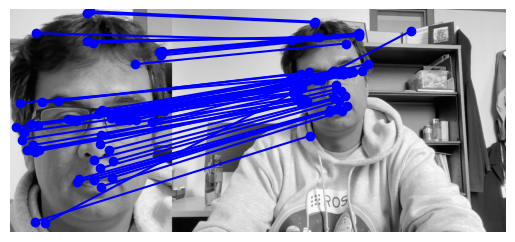

In [15]:
if __name__ == '__main__':
    template = cv2.imread('./JS_template.jpg', 0)  # read as grey scale image
    target_list = []
    for i in range(4):
        target = cv2.imread('./JS_target{}.jpg'.format(i+1), 0)  # read as grey scale image
        target_list.append(target)

    x1, x2 = find_match(template, target_list[0])
    visualize_find_match(template, target_list[0], x1, x2)

    # ransac_thr = 100
    # ransac_iter = 500
    # # print("No of Keypoints after find match : ", len(x1))
    # # A, x1_ret, x2_ret, x1_outliners, x2_outliners = align_image_using_feature(x1, x2, ransac_thr, ransac_iter)
    # A = align_image_using_feature(x1, x2, ransac_thr, ransac_iter)
    # # visualize_align_image_using_feature(template, target_list[0], x1, x2, A, ransac_thr, img_h=500)

    # img_warped = warp_image(target_list[0], A, template.shape)
    # # plt.imshow(img_warped, cmap='grey', vmin=0, vmax=255)
    # # plt.axis('off')
    # # plt.show()

    # plot_error_map = False
    # if plot_error_map:
    #     error_map = np.abs(img_warped - template)
    #     plt.imshow(error_map, cmap='plasma', vmin=0, vmax=255)
    #     plt.axis('off')
    #     plt.show()

    # # A_refined, errors = align_image(template, target_list[0], A)
    # A_refined, errors = align_image(template, target_list[1], A)   # Update from Prof.
    # # visualize_align_image(template, target_list[0], A, A_refined, errors)

    # A_list = track_multi_frames(template, target_list)
    # visualize_track_multi_frames(template, target_list, A_list)